In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00


In [ ]:
import nltk
import pandas as pd
#import sklearn_crfsuite
#from sklearn_crfsuite import metrics

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

root = '/content/gdrive/MyDrive/Colab Notebooks/torch/'
df = pd.read_csv(root+'data/NER-dataset/ner_dataset.csv', encoding = "ISO-8859-1")
# Annotated Corpus for Named Entity Recognition using GMB
# (Groningen Meaning Bank) corpus for named entity classification.
# https://www.kaggle.com/code/abhinavwalia95/how-to-loading-and-fitting-dataset-to-scikit/input
# https://github.com/iresiragusa/NLP/blob/main/datasets/ner_dataset.csv

Mounted at /content/gdrive


In [ ]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [ ]:
# TASK
#   POS tagging w/ CRF
#   NER tagging w/ CRF (Tag field in the dataset)

# note that in this notebook only NER tagging is done as in Esercitazione3a

In [ ]:
# custom train/test split due to RAM limitations

for i in range(len(df)):
  if df.at[i, 'Sentence #'] == 'Sentence: 16001':
    idx_train = i
  if df.at[i, 'Sentence #'] == 'Sentence: 20001':
    idx_test = i
    break

In [ ]:
df_train = df.iloc[:idx_train].reset_index()
df_test = df.iloc[idx_train:idx_test].reset_index()

In [ ]:
# ner tags in the dataset + Other tag
# ner are annotated via BIO encoding

#geo = Geographical Entity
#org = Organization
#per = Person
#gpe = Geopolitical Entity
#tim = Time indicator
#art = Artifact
#eve = Event
#nat = Natural Phenomenon

In [ ]:
df_train

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
349839,NaN,more,JJR,O
349840,NaN,than,IN,O
349841,NaN,"30,000",CD,O
349842,NaN,people,NNS,O


In [ ]:
# fill the NaN gaps in the dataframe

df_train = df_train.fillna(method='ffill')
print(df_train['Sentence #'].nunique(), df_train.Word.nunique(), df_train.Tag.nunique())

df_test = df_test.fillna(method='ffill')
print(df_test['Sentence #'].nunique(), df_test.Word.nunique(), df_test.Tag.nunique())

16000 20623 17
4000 10432 17


In [ ]:
df_train

,index,Sentence #,Word,POS,Tag
0,0,Sentence: 1,Thousands,NNS,O
1,1,Sentence: 1,of,IN,O
2,2,Sentence: 1,demonstrators,NNS,O
3,3,Sentence: 1,have,VBP,O
4,4,Sentence: 1,marched,VBN,O
...,...,...,...,...,...
349839,349839,Sentence: 16000,more,JJR,O
349840,349840,Sentence: 16000,than,IN,O
349841,349841,Sentence: 16000,"30,000",CD,O
349842,349842,Sentence: 16000,people,NNS,O


      Tag  counts
0   B-art     157
1   B-eve     131
2   B-geo   12334
3   B-gpe    5532
4   B-nat      75
5   B-org    6668
6   B-per    5654
7   B-tim    6656
8   I-art     104
9   I-eve     111
10  I-geo    2454
11  I-gpe      84
12  I-nat      30
13  I-org    5406
14  I-per    5856
15  I-tim    2053
16      O  296539


<Axes: xlabel='Tag'>

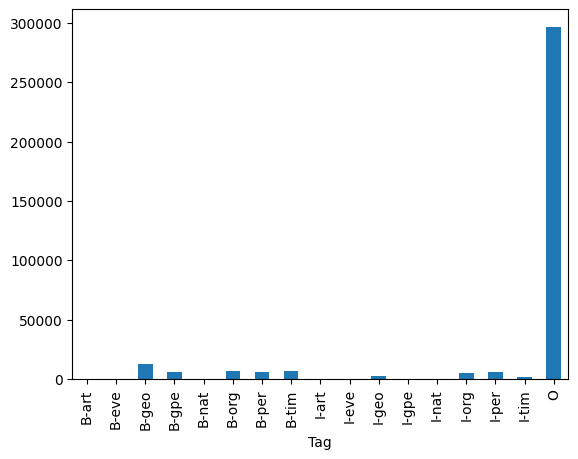

In [ ]:
# getting statistics of the dataframe
print(df_train.groupby('Tag').size().reset_index(name='counts'))
df_train.groupby(['Tag']).size().plot.bar()

      Tag  counts
0   B-art      16
1   B-eve      29
2   B-geo    3173
3   B-gpe    1319
4   B-nat      11
5   B-org    1672
6   B-per    1375
7   B-tim    1690
8   I-art      20
9   I-eve      22
10  I-geo     638
11  I-gpe       8
12  I-nat       1
13  I-org    1430
14  I-per    1446
15  I-tim     572
16      O   74690


<Axes: xlabel='Tag'>

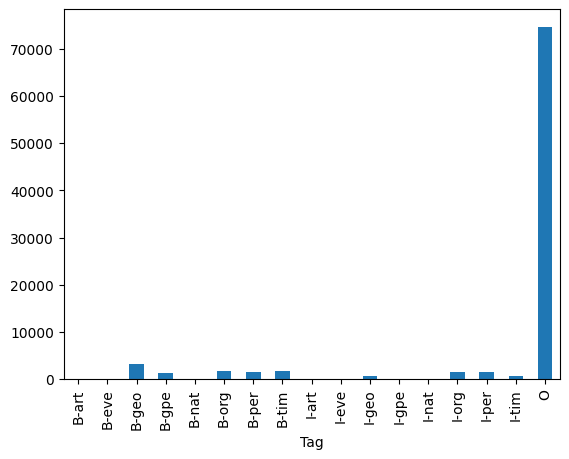

In [ ]:
print(df_test.groupby('Tag').size().reset_index(name='counts'))
df_test.groupby(['Tag']).size().plot.bar()

In [ ]:
# reduce in the Penn Treebank from nltk format
def get_sentences(df):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
  grouped = df.groupby('Sentence #').apply(agg_func)
  sentences = [s for s in grouped]
  return sentences

sentences_train = get_sentences(df_train)
sentences_test = get_sentences(df_test)

In [ ]:
sentences_test[0]

[('Turkey', 'NNP', 'B-geo'),
 (',', ',', 'O'),
 ('the', 'DT', 'O'),
 ('United', 'NNP', 'B-geo'),
 ('States', 'NNPS', 'I-geo'),
 ('and', 'CC', 'O'),
 ('other', 'JJ', 'O'),
 ('nations', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('designated', 'VBN', 'O'),
 ('the', 'DT', 'O'),
 ('PKK', 'NNP', 'B-org'),
 ('a', 'DT', 'O'),
 ('terrorist', 'JJ', 'O'),
 ('group', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
# Define a function to extract features for each word in a sentence
# here we consider different features, other features may be added or removed
# try to change them and check model's performances

def word_features(sentence, i):
	word = sentence[i][0]
	features = {
		'word': word,
		'POS': sentence[i][1],
		'is_first': i == 0, #if the word is a first word
		'is_last': i == len(sentence) - 1, #if the word is a last word
		'is_capitalized': word[0].upper() == word[0],
		'is_all_caps': word.upper() == word,	 #word is in uppercase
		'is_all_lower': word.lower() == word,	 #word is in lowercase
		#prefix of the word
		'prefix-1': word[0],
		'prefix-2': word[:2],
		'prefix-3': word[:3],
		#suffix of the word
		'suffix-1': word[-1],
		'suffix-2': word[-2:],
		'suffix-3': word[-3:],
		#extracting previous word
		'prev_word': '' if i == 0 else sentence[i-1][0],
		#extracting next word
		'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],
		'has_hyphen': '-' in word, #if word has hypen
		'is_numeric': word.isdigit(), #if word is in numeric
		'capitals_inside': word[1:].lower() != word[1:]
	}
	return features

In [ ]:
# Extract features for each sentence in the corpus
# Here we consieder NER tag as label, try to predict POS tag instead
# and do not forget to remove the POS from the word feature

def get_features(sentences):
	x = []
	y = []
	for sentence in sentences:
		x_sentence = []
		y_sentence = []
		for i in range(len(sentence)):
			x_sentence.append(word_features(sentence, i))
			y_sentence.append(sentence[i][2])
		x.append(x_sentence)
		y.append(y_sentence)
	return x, y

x_train, y_train = get_features(sentences_train)
x_test, y_test = get_features(sentences_test)

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

In [ ]:
# try to change hyperparamenters and see how the model changes its performance

# Train a CRF model on the training data
crf = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	c1=0.1,
	c2=0.1,
	max_iterations=100,
	all_possible_transitions=True
)

In [ ]:
print(x_train[0])
print(y_train[0])

[{'word': 'Thousands', 'POS': 'NNS', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'T', 'prefix-2': 'Th', 'prefix-3': 'Tho', 'suffix-1': 's', 'suffix-2': 'ds', 'suffix-3': 'nds', 'prev_word': '', 'next_word': 'of', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}, {'word': 'of', 'POS': 'IN', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'o', 'prefix-2': 'of', 'prefix-3': 'of', 'suffix-1': 'f', 'suffix-2': 'of', 'suffix-3': 'of', 'prev_word': 'Thousands', 'next_word': 'demonstrators', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}, {'word': 'demonstrators', 'POS': 'NNS', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'd', 'prefix-2': 'de', 'prefix-3': 'dem', 'suffix-1': 's', 'suffix-2': 'rs', 'suffix-3': 'ors', 'prev_word': 'of', 'next_w

In [ ]:
try:
  crf.fit(x_train, y_train)
except AttributeError:
    pass

In [ ]:
# Make predictions on the test data and evaluate the performance
y_pred = crf.predict(x_test)

print('Accuracy on the test set = {}'.format(metrics.flat_accuracy_score(y_test, y_pred)))
print('F1 score on the test set = {}'.format(metrics.flat_f1_score(y_test, y_pred, average='weighted')))

Accuracy on the test set = 0.9686875794443436
F1 score on the test set = 0.9683801911704015


In [ ]:
from itertools import chain
from sklearn.metrics import classification_report

f_y_test = list(chain.from_iterable(y_test))
f_pred_y = list(chain.from_iterable(y_pred))

print('Test set classification report: \n\n{}'.format(classification_report(f_y_test, f_pred_y)))

Test set classification report: 

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        16
       B-eve       0.48      0.41      0.44        29
       B-geo       0.84      0.90      0.87      3173
       B-gpe       0.96      0.95      0.95      1319
       B-nat       0.23      0.27      0.25        11
       B-org       0.78      0.70      0.74      1672
       B-per       0.79      0.80      0.80      1375
       B-tim       0.93      0.88      0.90      1690
       I-art       0.00      0.00      0.00        20
       I-eve       0.35      0.32      0.33        22
       I-geo       0.80      0.81      0.81       638
       I-gpe       0.67      0.50      0.57         8
       I-nat       0.17      1.00      0.29         1
       I-org       0.80      0.74      0.77      1430
       I-per       0.83      0.89      0.85      1446
       I-tim       0.84      0.75      0.79       572
           O       0.99      0.99      0.99    

In [ ]:
# get prediction without the O class that unbalance the dataset and the results of the classifier
# ie how is the performance of our classifier despite the O class?

import numpy as np
y = df.Tag.values
classes = np.unique(y)
classes = classes.tolist()
print(classes)
new_classes = classes.copy()
new_classes.pop()
print(new_classes)

['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']
['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim']


In [ ]:
print('Test set classification report: \n\n{}'.format(classification_report(f_y_test, f_pred_y, labels=new_classes)))

Test set classification report: 

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        16
       B-eve       0.48      0.41      0.44        29
       B-geo       0.84      0.90      0.87      3173
       B-gpe       0.96      0.95      0.95      1319
       B-nat       0.23      0.27      0.25        11
       B-org       0.78      0.70      0.74      1672
       B-per       0.79      0.80      0.80      1375
       B-tim       0.93      0.88      0.90      1690
       I-art       0.00      0.00      0.00        20
       I-eve       0.35      0.32      0.33        22
       I-geo       0.80      0.81      0.81       638
       I-gpe       0.67      0.50      0.57         8
       I-nat       0.17      1.00      0.29         1
       I-org       0.80      0.74      0.77      1430
       I-per       0.83      0.89      0.85      1446
       I-tim       0.84      0.75      0.79       572

   micro avg       0.84      0.83      0.84   